# Runtime Comparison: Sequential vs. Async DORAnetMCTS

This notebook compares the runtime performance of sequential (`DORAnetMCTS`) and asynchronous (`AsyncExpansionDORAnetMCTS`) implementations for the target molecule **5,6-dihydroyangonin**.

**Target molecule**: 5,6-dihydroyangonin  
**SMILES**: `COC1=CC(OC(C=CC2=CC=C(OC)C=C2)C1)=O`

## 1. Setup and Imports

In [5]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem import rdMolDescriptors

# Matplotlib styling
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Repository root
REPO_ROOT = Path('../').resolve()
print(f"Repository root: {REPO_ROOT}")

Repository root: /Users/yashchainani/Desktop/PythonProjects/RL_agents_for_retrosynthesis


## 2. Define Target Molecule

Target: 5,6-dihydroyangonin
SMILES: COC1=CC(OC(C=CC2=CC=C(OC)C=C2)C1)=O
Molecular formula: C15H16O4
Molecular weight: 260.29 g/mol


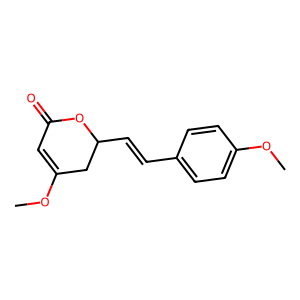

In [6]:
# 5,6-dihydroyangonin
TARGET_SMILES = "COC1=CC(OC(C=CC2=CC=C(OC)C=C2)C1)=O"
TARGET_NAME = "5,6-dihydroyangonin"

# Validate SMILES
target_mol = Chem.MolFromSmiles(TARGET_SMILES)
if target_mol is None:
    raise ValueError(f"Invalid SMILES: {TARGET_SMILES}")

print(f"Target: {TARGET_NAME}")
print(f"SMILES: {TARGET_SMILES}")
print(f"Molecular formula: {rdMolDescriptors.CalcMolFormula(target_mol)}")
print(f"Molecular weight: {Descriptors.MolWt(target_mol):.2f} g/mol")

# Display molecule
Draw.MolToImage(target_mol, size=(300, 300))

## 3. Load Benchmark Results

In [ ]:
def parse_benchmark_file(filepath):
    """
    Parse a benchmark result text file and extract metrics.
    
    Returns a dictionary with the extracted values.
    """
    with open(filepath, 'r') as f:
        content = f.read()
    
    # Extract metrics using regex
    def extract_value(pattern, text, default=None):
        match = re.search(pattern, text)
        return match.group(1).strip() if match else default
    
    result = {
        'mode': extract_value(r'Mode:\s+(\w+)', content),
        'molecule': extract_value(r'Molecule:\s+(\S+)', content),
        'smiles': extract_value(r'SMILES:\s+(\S+)', content),
        'timestamp': extract_value(r'Timestamp:\s+(\S+)', content),
        'total_iterations': int(extract_value(r'Total iterations:\s+(\d+)', content, '0')),
        'max_depth': int(extract_value(r'Max depth:\s+(\d+)', content, '0')),
        'runtime_seconds': float(extract_value(r'Total runtime:\s+([\d.]+)', content, '0')),
        'total_nodes': int(extract_value(r'Total nodes:\s+(\d+)', content, '0')),
        'unique_smiles': extract_value(r'Unique SMILES:\s+(\d+)', content, None),
        'terminal_nodes': int(extract_value(r'Terminal nodes:\s+(\d+)', content, '0')),
        'sink_compounds': int(extract_value(r'Sink compounds:\s+(\d+)', content, '0')),
        'pks_matches': int(extract_value(r'PKS matches:\s+(\d+)', content, '0')),
        'num_workers': extract_value(r'Num workers:\s+(\d+)', content, 'N/A'),
    }
    
    # Convert num_workers to int if it's a number
    if result['num_workers'] != 'N/A':
        result['num_workers'] = int(result['num_workers'])
    
    # Convert unique_smiles to int if present
    if result['unique_smiles'] is not None:
        result['unique_smiles'] = int(result['unique_smiles'])
    
    return result

print("Benchmark file parser defined.")

In [8]:
# Benchmark result files
benchmarks_dir = REPO_ROOT / "results/benchmarks"

seq_benchmark_file = benchmarks_dir / "benchmark_runtime_sequential_5_6_dihydroyangonin_20260129_010444.txt"
async_benchmark_file = benchmarks_dir / "benchmark_runtime_async_5_6_dihydroyangonin_20260129_005933.txt"

# Verify files exist
print("Benchmark files:")
print(f"  Sequential: {seq_benchmark_file.name} - {'EXISTS' if seq_benchmark_file.exists() else 'MISSING'}")
print(f"  Async: {async_benchmark_file.name} - {'EXISTS' if async_benchmark_file.exists() else 'MISSING'}")

Benchmark files:
  Sequential: benchmark_runtime_sequential_5_6_dihydroyangonin_20260129_010444.txt - EXISTS
  Async: benchmark_runtime_async_5_6_dihydroyangonin_20260129_005933.txt - EXISTS


In [9]:
# Parse benchmark files
seq_results = parse_benchmark_file(seq_benchmark_file)
async_results = parse_benchmark_file(async_benchmark_file)

print("Sequential Benchmark Results:")
for key, value in seq_results.items():
    print(f"  {key}: {value}")

print("\nAsync Benchmark Results:")
for key, value in async_results.items():
    print(f"  {key}: {value}")

Sequential Benchmark Results:
  mode: sequential
  molecule: 5_6_dihydroyangonin
  smiles: COC1=CC(OC(C=CC2=CC=C(OC)C=C2)C1)=O
  timestamp: 20260129_010444
  total_iterations: 50
  max_depth: 3
  runtime_seconds: 609.7446
  total_nodes: 6457
  terminal_nodes: 126
  sink_compounds: 63
  pks_matches: 63
  num_workers: N/A

Async Benchmark Results:
  mode: async
  molecule: 5_6_dihydroyangonin
  smiles: COC1=CC(OC(C=CC2=CC=C(OC)C=C2)C1)=O
  timestamp: 20260129_005933
  total_iterations: 50
  max_depth: 3
  runtime_seconds: 214.4114
  total_nodes: 10043
  terminal_nodes: 262
  sink_compounds: 131
  pks_matches: 131
  num_workers: 11


## 4. Runtime Comparison Summary

In [ ]:
# Extract key metrics
seq_runtime = seq_results['runtime_seconds']
async_runtime = async_results['runtime_seconds']
num_workers = async_results['num_workers']

# Calculate speedup
speedup = seq_runtime / async_runtime if async_runtime > 0 else float('inf')

# Helper to format unique_smiles (may be None for older benchmarks)
def format_unique_smiles(results):
    if results['unique_smiles'] is not None:
        return str(results['unique_smiles'])
    return 'N/A (re-run benchmark)'

# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': [
        'Runtime (seconds)',
        'Total iterations',
        'Max depth',
        'Total nodes (tree)',
        'Unique molecules',
        'Sink compounds',
        'PKS matches',
        'Terminal nodes',
        'Nodes/second',
        'Workers'
    ],
    'Sequential': [
        f"{seq_results['runtime_seconds']:.2f}",
        seq_results['total_iterations'],
        seq_results['max_depth'],
        seq_results['total_nodes'],
        format_unique_smiles(seq_results),
        seq_results['sink_compounds'],
        seq_results['pks_matches'],
        seq_results['terminal_nodes'],
        f"{seq_results['total_nodes'] / seq_results['runtime_seconds']:.2f}",
        '1'
    ],
    'Async': [
        f"{async_results['runtime_seconds']:.2f}",
        async_results['total_iterations'],
        async_results['max_depth'],
        async_results['total_nodes'],
        format_unique_smiles(async_results),
        async_results['sink_compounds'],
        async_results['pks_matches'],
        async_results['terminal_nodes'],
        f"{async_results['total_nodes'] / async_results['runtime_seconds']:.2f}",
        str(async_results['num_workers'])
    ]
})

print("="*60)
print("RUNTIME COMPARISON SUMMARY")
print("="*60)
print(f"\nTarget: {TARGET_NAME}")
print(f"Iterations: {seq_results['total_iterations']}")
print(f"Async workers: {num_workers}")
print()
display(comparison_df)

print(f"\n{'='*60}")
print(f"SPEEDUP: {speedup:.2f}x")
print(f"{'='*60}")

if speedup > 1:
    print(f"\nAsync is {speedup:.2f}x faster than sequential")
    print(f"Time saved: {seq_runtime - async_runtime:.2f} seconds ({(1 - async_runtime/seq_runtime)*100:.1f}%)")
elif speedup < 1:
    print(f"\nSequential is {1/speedup:.2f}x faster than async")
else:
    print(f"\nBoth methods have similar performance")

# Note about node counts
print("\n" + "-"*60)
print("NOTE: 'Total nodes' = tree nodes (same molecule can appear")
print("      multiple times via different reaction paths)")
print("      'Unique molecules' = distinct canonical SMILES explored")

## 5. Visualize Runtime Comparison

Figure saved to: ../figures/sequential_vs_async_runtime_comparison.png


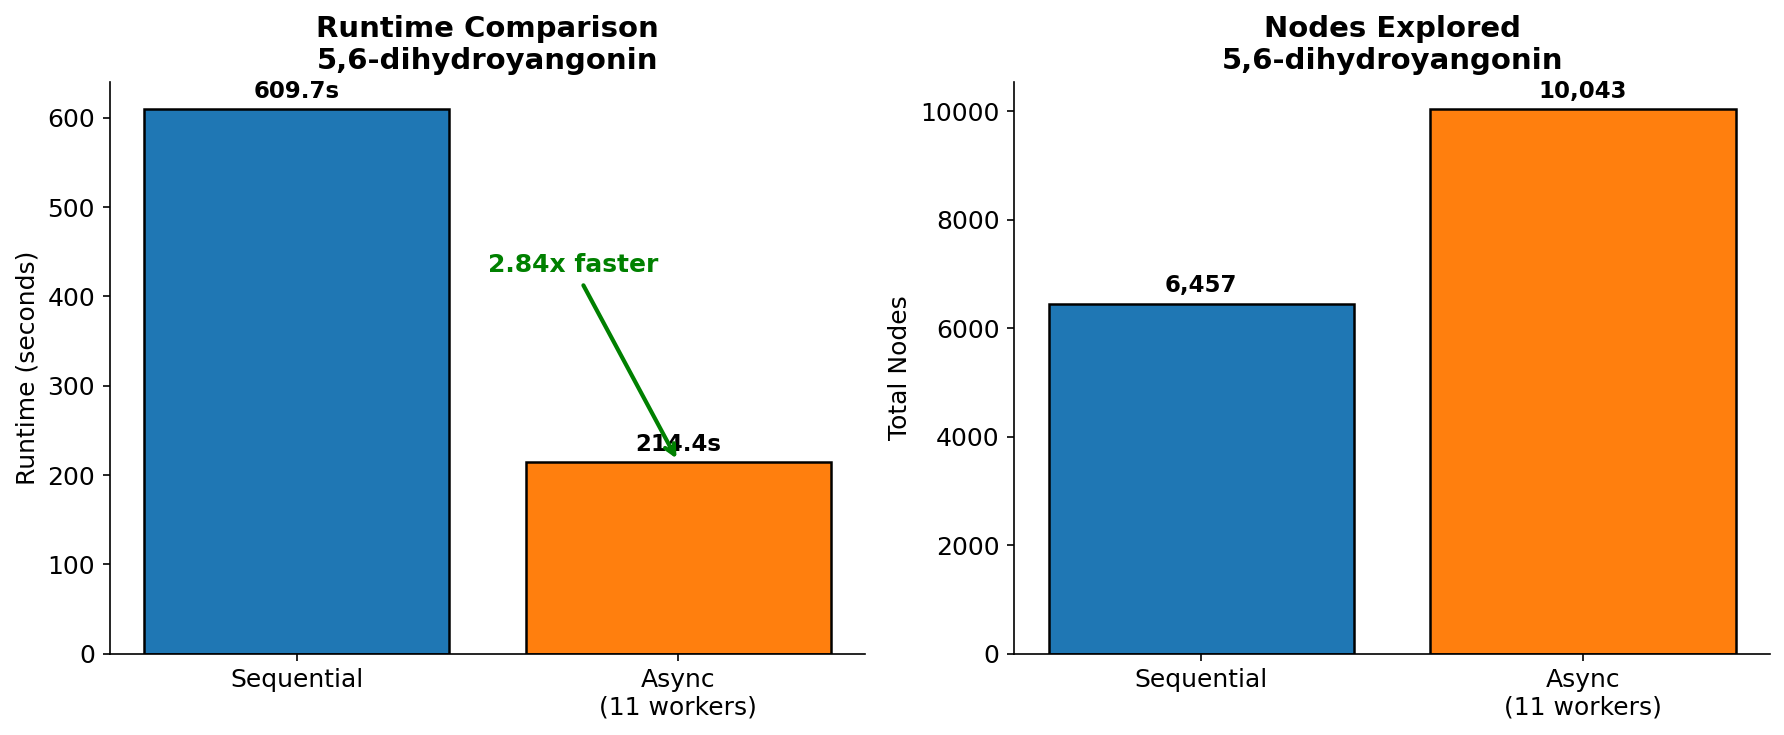

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart: Runtime comparison
ax1 = axes[0]
methods = ['Sequential', f'Async\n({num_workers} workers)']
runtimes = [seq_runtime, async_runtime]
colors = ['#1f77b4', '#ff7f0e']

bars = ax1.bar(methods, runtimes, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Runtime (seconds)', fontsize=12)
ax1.set_title(f'Runtime Comparison\n{TARGET_NAME}', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar, runtime in zip(bars, runtimes):
    height = bar.get_height()
    ax1.annotate(f'{runtime:.1f}s',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add speedup annotation
ax1.annotate(f'{speedup:.2f}x faster',
            xy=(1, async_runtime),
            xytext=(0.5, seq_runtime * 0.7),
            fontsize=12, fontweight='bold', color='green',
            arrowprops=dict(arrowstyle='->', color='green', lw=2))

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Bar chart: Nodes explored
ax2 = axes[1]
nodes = [seq_results['total_nodes'], async_results['total_nodes']]

bars2 = ax2.bar(methods, nodes, color=colors, edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Total Nodes', fontsize=12)
ax2.set_title(f'Nodes Explored\n{TARGET_NAME}', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar, n in zip(bars2, nodes):
    height = bar.get_height()
    ax2.annotate(f'{n:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
figures_dir = Path('../figures')
figures_dir.mkdir(parents=True, exist_ok=True)
save_path = figures_dir / 'sequential_vs_async_runtime_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## 6. Throughput Comparison

In [ ]:
# Calculate throughput metrics
seq_throughput = seq_results['total_nodes'] / seq_results['runtime_seconds']
async_throughput = async_results['total_nodes'] / async_results['runtime_seconds']

seq_iter_rate = seq_results['total_iterations'] / seq_results['runtime_seconds']
async_iter_rate = async_results['total_iterations'] / async_results['runtime_seconds']

fig, ax = plt.subplots(figsize=(8, 6))

metrics = ['Nodes/second', 'Iterations/second']
seq_values = [seq_throughput, seq_iter_rate]
async_values = [async_throughput, async_iter_rate]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, seq_values, width, label='Sequential', color='#1f77b4', edgecolor='black')
bars2 = ax.bar(x + width/2, async_values, width, label=f'Async ({num_workers} workers)', color='#ff7f0e', edgecolor='black')

ax.set_ylabel('Rate', fontsize=12)
ax.set_title(f'Throughput Comparison\n{TARGET_NAME}', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

save_path = figures_dir / 'sequential_vs_async_throughput.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## 7. Terminal Nodes Comparison

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Sink Compounds', 'PKS Matches', 'Total Terminal']
seq_terminal = [seq_results['sink_compounds'], seq_results['pks_matches'], seq_results['terminal_nodes']]
async_terminal = [async_results['sink_compounds'], async_results['pks_matches'], async_results['terminal_nodes']]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, seq_terminal, width, label='Sequential', color='#1f77b4', edgecolor='black')
bars2 = ax.bar(x + width/2, async_terminal, width, label=f'Async ({num_workers} workers)', color='#ff7f0e', edgecolor='black')

ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Terminal Nodes Found\n{TARGET_NAME}', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

save_path = figures_dir / 'sequential_vs_async_terminal_nodes.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## 8. Efficiency Analysis

In [ ]:
# Calculate efficiency metrics
seq_terminals_per_second = seq_results['terminal_nodes'] / seq_results['runtime_seconds']
async_terminals_per_second = async_results['terminal_nodes'] / async_results['runtime_seconds']

# Parallel efficiency: actual speedup / ideal speedup (num_workers)
ideal_speedup = num_workers if isinstance(num_workers, int) else 1
parallel_efficiency = (speedup / ideal_speedup) * 100

print("="*60)
print("EFFICIENCY ANALYSIS")
print("="*60)
print(f"\nTerminal nodes per second:")
print(f"  Sequential: {seq_terminals_per_second:.4f}")
print(f"  Async:      {async_terminals_per_second:.4f}")
print(f"  Improvement: {async_terminals_per_second / seq_terminals_per_second:.2f}x")

print(f"\nParallel efficiency:")
print(f"  Actual speedup: {speedup:.2f}x")
print(f"  Ideal speedup (with {num_workers} workers): {ideal_speedup}x")
print(f"  Parallel efficiency: {parallel_efficiency:.1f}%")

print(f"\nNote: Async explored {async_results['total_nodes'] - seq_results['total_nodes']} more nodes")
print(f"      ({(async_results['total_nodes'] / seq_results['total_nodes'] - 1) * 100:.1f}% more)")
print(f"      and found {async_results['terminal_nodes'] - seq_results['terminal_nodes']} more terminal nodes")
print(f"      ({(async_results['terminal_nodes'] / seq_results['terminal_nodes'] - 1) * 100:.1f}% more)")

## 9. Final Summary

In [ ]:
print("="*70)
print("FINAL SUMMARY: Sequential vs. Async DORAnetMCTS")
print("="*70)
print(f"\nTarget molecule: {TARGET_NAME}")
print(f"SMILES: {TARGET_SMILES}")
print(f"\nConfiguration:")
print(f"  - Iterations: {seq_results['total_iterations']}")
print(f"  - Max depth: {seq_results['max_depth']}")
print(f"  - Async workers: {num_workers}")
print(f"\nRuntime Results:")
print(f"  Sequential runtime: {seq_runtime:.2f} seconds ({seq_runtime/60:.1f} min)")
print(f"  Async runtime:      {async_runtime:.2f} seconds ({async_runtime/60:.1f} min)")
print(f"  Speedup:            {speedup:.2f}x")
print(f"  Time saved:         {seq_runtime - async_runtime:.2f} seconds ({(seq_runtime - async_runtime)/60:.1f} min)")
print(f"\nExploration Results:")
print(f"  Sequential tree nodes:   {seq_results['total_nodes']:,}")
print(f"  Async tree nodes:        {async_results['total_nodes']:,}")
if seq_results['unique_smiles'] is not None and async_results['unique_smiles'] is not None:
    print(f"  Sequential unique molecules: {seq_results['unique_smiles']:,}")
    print(f"  Async unique molecules:      {async_results['unique_smiles']:,}")
else:
    print(f"  Unique molecules: N/A (re-run benchmarks to collect this metric)")
print(f"\nTerminal Nodes Found:")
print(f"  Sequential: {seq_results['terminal_nodes']} ({seq_results['sink_compounds']} sink + {seq_results['pks_matches']} PKS)")
print(f"  Async:      {async_results['terminal_nodes']} ({async_results['sink_compounds']} sink + {async_results['pks_matches']} PKS)")
print("="*70)